In [78]:
import torch
from torch import nn
from torch.nn import functional as F

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import time
from tabulate import tabulate


from trainer import Trainer, generate_data_iter
import utils
import attack
import cam

In [79]:
model_mode, dataset, seed, cuda = 'resnet18', 'FashionMNIST', 2, 0
target_layer = 'layer4' if model_mode == 'resnet18' else 'blocks'
fig_num = 400
metrics = {}

utils.set_random_seed(seed)
trainer = Trainer(
    model_mode = model_mode,
    dataset = dataset,
    bs = 128,
    lr = 0.01,
    seed = seed,
    cuda = cuda,
    use_lr_sche = True,
    use_wandb = False,
)
trainer.load()
scorecam = cam.ScoreCAM(trainer.model, dataset, target_layer, cuda = cuda)

# Generate Test data
test_iter = generate_data_iter(dataset, batch_size = fig_num, mode = 'test')
imgs, labels = next(iter(test_iter))
raw_cam_nps, raw_preds, _, __ = scorecam(imgs, metric = False)

# Extract Successful Results
suc_indices = raw_preds == labels
suc_imgs, suc_labels = imgs[suc_indices], labels[suc_indices]
suc_cams, suc_saliency_maps, suc_preds, suc_probs, suc_cam_metrics \
    = scorecam(suc_imgs, metric = True, saliency = True)


metrics['Raw'] = {
    'time': 0,
    'success_rate': 1,
    'delta_norm': 0,
    'Average Incr': suc_cam_metrics['Average Incr'], 
    'Average Drop': suc_cam_metrics['Average Drop'],
    'Insertion':  suc_cam_metrics['Insertion'], 
    'Deletion': suc_cam_metrics['Deletion'],
    'saliency_diff': 0,
    'shift_dist': 0
}
print(tabulate(
    list(metrics['Raw'].items()), tablefmt ='orgtbl'
))

| time          | 0         |
| success_rate  | 1         |
| delta_norm    | 0         |
| Average Incr  | 0.327225  |
| Average Drop  | 0.0066161 |
| Insertion     | 0.58016   |
| Deletion      | 0.370621  |
| saliency_diff | 0         |
| shift_dist    | 0         |


In [80]:
def test_advatt(att, max_iter: int = None, att_kwargs: dict = {}):
    start = time.time()
    att_imgs = att(
        suc_imgs, suc_labels, max_iter = max_iter, 
        num_classes = 10, attack_kwargs = att_kwargs
    )
    finish = time.time()
    deltas = att_imgs - suc_imgs
    
    att_preds, _ = scorecam.model_predict(scorecam.tfm(att_imgs))
    
    # Success Rate
    indices = att_preds != suc_labels
    success_rate = indices.sum() / len(att_preds)

    # delta norm
    delta_norm = torch.mean(
        torch.linalg.norm(deltas.reshape(len(deltas), -1), dim = 1) \
            / torch.linalg.norm(suc_imgs.reshape(len(deltas), -1), dim = 1)
    )
    
    # In cam part, we only focus on successful part
    att_suc_cams, att_suc_saliency, _, __, att_suc_cam_metrics \
        = scorecam(att_imgs[indices], metric = True, saliency = True)

    # delta saliency map norm
    saliency_diff = np.linalg.norm(
        att_suc_saliency - suc_saliency_maps[indices.numpy()],
        axis = (1, 2)
    ).mean()

    # maximum shift
    size = imgs.shape[-1]
    suc_max_idx_raw = np.argmax(
        suc_saliency_maps[indices.numpy()].reshape(indices.sum(), -1), axis = 1
    )
    suc_max_x, suc_max_y = suc_max_idx_raw // size, suc_max_idx_raw % size

    att_max_idx_raw = np.argmax(att_suc_saliency.reshape(len(att_suc_saliency), -1), axis = 1)
    att_max_x, att_max_y = att_max_idx_raw // size, suc_max_idx_raw % size
    shift_dist = np.sqrt((att_max_x - suc_max_x)**2 + (att_max_y - suc_max_y)**2).mean()
    
    metrics = {
        'time': finish - start,
        'success_rate': success_rate.item(),
        'delta_norm': delta_norm.item(),
        'Average Incr': att_suc_cam_metrics['Average Incr'], 
        'Average Drop': att_suc_cam_metrics['Average Drop'],
        'Insertion':  att_suc_cam_metrics['Insertion'], 
        'Deletion': att_suc_cam_metrics['Deletion'],
        'saliency_diff': saliency_diff,
        'shift_dist': shift_dist
    }
    return att_imgs, att_suc_cams, indices.numpy(), metrics

def plot_imgs(
    raw_img: torch.Tensor,
    att_img: torch.Tensor,
    suc_cam: np.ndarray,
    att_cam: np.ndarray
):
    fig = plt.figure(figsize = (12, 3))
    plt.subplot(1, 4, 1)
    plt.imshow(np.transpose(raw_img.numpy(), (1, 2, 0)))
    plt.title('Raw')
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.imshow(np.transpose(att_img.numpy(), (1, 2, 0)))
    plt.title('Attack')
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    plt.imshow(suc_cam)
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.imshow(att_cam)
    plt.axis('off')

### FGSM

In [81]:
att = attack.FGSM(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 0.03}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 382/382 [00:05<00:00, 75.33it/s]


| time          | 5.07373   |
| success_rate  | 0.363874  |
| delta_norm    | 0.0651734 |
| Average Incr  | 0.460432  |
| Average Drop  | 0.0988808 |
| Insertion     | 0.408656  |
| Deletion      | 0.208879  |
| saliency_diff | 9.10346   |
| shift_dist    | 5.78417   |


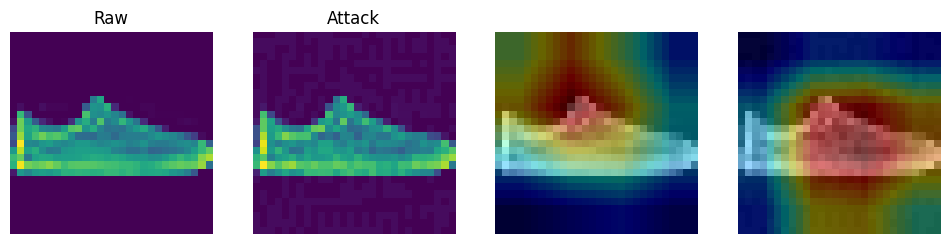

In [82]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### FGM

In [83]:
att = attack.FGM(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 0.8}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 382/382 [00:05<00:00, 75.99it/s]


| time          | 5.02946   |
| success_rate  | 0.340314  |
| delta_norm    | 0.0649621 |
| Average Incr  | 0.461538  |
| Average Drop  | 0.0772269 |
| Insertion     | 0.374731  |
| Deletion      | 0.19581   |
| saliency_diff | 8.70705   |
| shift_dist    | 5.23077   |


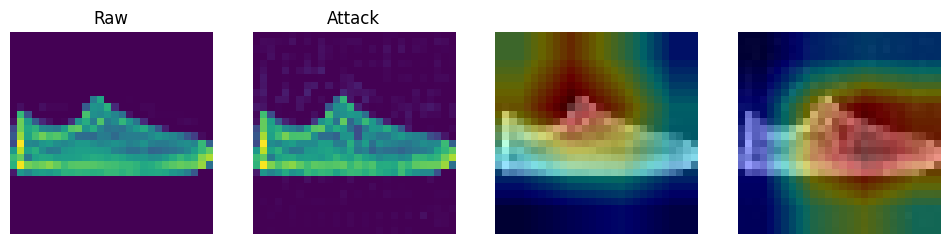

In [84]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### Step-LL

In [85]:
att = attack.StepLL(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 0.035}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 382/382 [00:06<00:00, 54.92it/s]


| time          | 6.96198   |
| success_rate  | 0.337696  |
| delta_norm    | 0.0760705 |
| Average Incr  | 0.627907  |
| Average Drop  | 0.13803   |
| Insertion     | 0.30253   |
| Deletion      | 0.163678  |
| saliency_diff | 9.10319   |
| shift_dist    | 6.08527   |


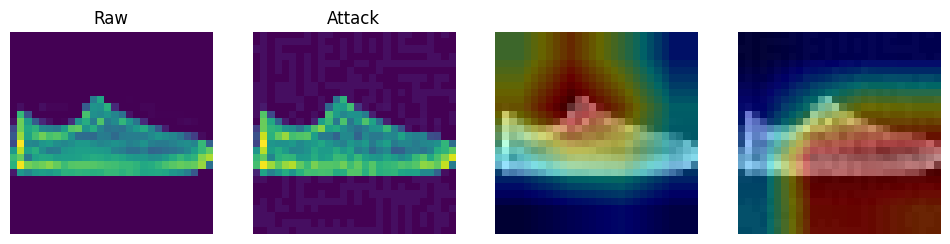

In [86]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### I-FGSM

In [87]:
att = attack.IFGSM(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 0.015}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, max_iter = 10, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 382/382 [00:48<00:00,  7.82it/s]


| time          | 48.856     |
| success_rate  |  0.979058  |
| delta_norm    |  0.0615096 |
| Average Incr  |  0.0187166 |
| Average Drop  |  0.28942   |
| Insertion     |  0.484714  |
| Deletion      |  0.253569  |
| saliency_diff |  8.43971   |
| shift_dist    |  5.37433   |


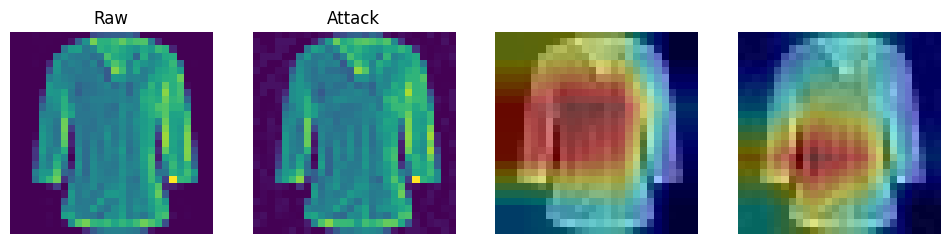

In [88]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### MI-FGSM

In [89]:
att = attack.MIFGSM(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 0.015}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, max_iter = 10, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 382/382 [00:56<00:00,  6.77it/s]


| time          | 56.4339    |
| success_rate  |  0.984293  |
| delta_norm    |  0.0626029 |
| Average Incr  |  0.0132979 |
| Average Drop  |  0.283455  |
| Insertion     |  0.478852  |
| Deletion      |  0.256112  |
| saliency_diff |  8.44555   |
| shift_dist    |  5.30319   |


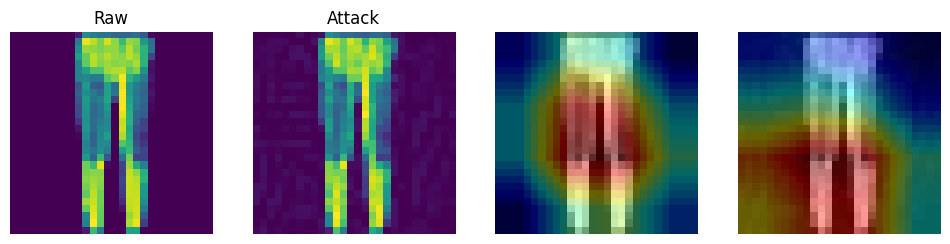

In [90]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### NIFGSM

In [91]:
att = attack.NIFGSM(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 0.015}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, max_iter = 10, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 382/382 [00:48<00:00,  7.92it/s]


| time          | 48.2666    |
| success_rate  |  0.984293  |
| delta_norm    |  0.0625924 |
| Average Incr  |  0.0159574 |
| Average Drop  |  0.285937  |
| Insertion     |  0.481862  |
| Deletion      |  0.254364  |
| saliency_diff |  8.48929   |
| shift_dist    |  5.39894   |


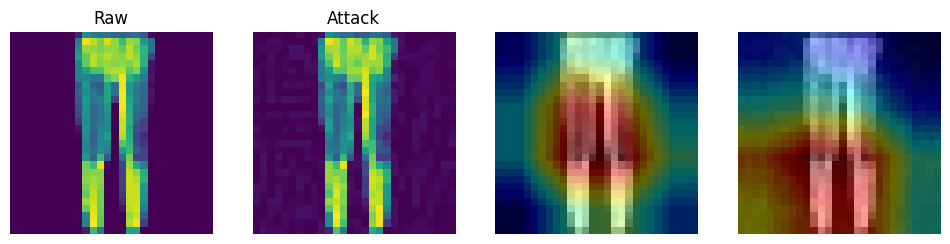

In [92]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### PGD

In [93]:
att = attack.PGD(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 0.035}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, max_iter = 10, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

 34%|███▍      | 130/382 [00:16<00:31,  8.03it/s]

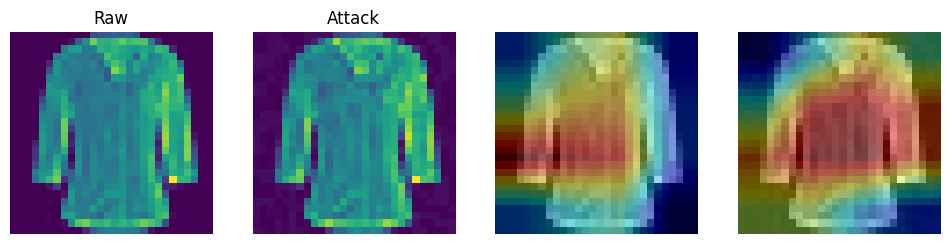

In [ ]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

## IterLL

In [ ]:
att = attack.IterLL(trainer.model, cuda)
att_name = att.__class__.__name__
att_kwargs = {'eps': 0.012}
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, max_iter = 10, att_kwargs = att_kwargs)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 385/385 [00:50<00:00,  7.65it/s]


| time          | 50.3068    |
| success_rate  |  0.74026   |
| delta_norm    |  0.0506384 |
| Average Incr  |  0.168421  |
| Average Drop  |  0.579232  |
| Insertion     |  0.259352  |
| Deletion      |  0.119729  |
| saliency_diff |  9.24711   |
| shift_dist    |  6.82105   |


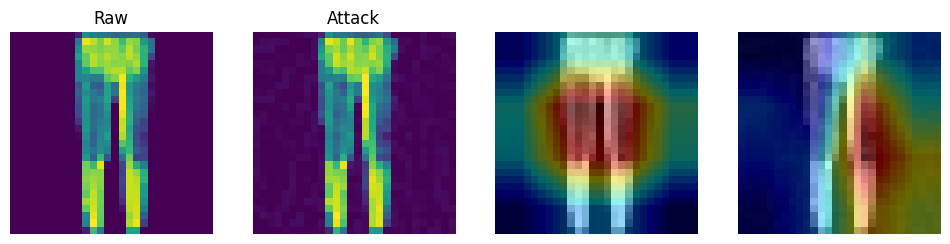

In [ ]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### Deep Fool

In [ ]:
att = attack.DeepFool(trainer.model, cuda)
att_name = att.__class__.__name__
att_imgs, att_suc_cams, indices, metrics[att_name] \
    = test_advatt(att, max_iter = 10)
print(tabulate(
    list(metrics[att_name].items()), tablefmt ='orgtbl'
))

100%|██████████| 385/385 [00:41<00:00,  9.26it/s]


| time          | 41.5605   |
| success_rate  |  1        |
| delta_norm    |  0.605597 |
| Average Incr  |  0.581818 |
| Average Drop  |  0.105064 |
| Insertion     |  0.328907 |
| Deletion      |  0.308948 |
| saliency_diff |  8.37816  |
| shift_dist    |  5.71688  |


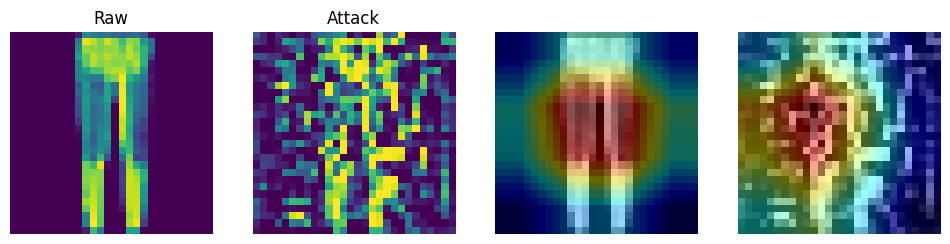

In [ ]:
idx = 3
plot_imgs(
    suc_imgs[indices][idx], att_imgs[indices][idx], 
    suc_cams[indices][idx], att_suc_cams[idx]
)

### One Pixel

In [ ]:
# att = attack.OnePixel(trainer.model)
# att_name = att.__class__.__name__
# att_imgs = torch.zeros_like(suc_imgs)
# start = time.time()
# with trange(len(suc_imgs)) as t:
#     for i in t:
#         att_imgs[i] = att(suc_imgs[i], suc_labels[i], 100, 400)
# final = time.time()

# deltas = att_imgs - suc_imgs
# norm = torch.mean(
#     torch.linalg.norm(deltas.reshape(len(deltas), -1), dim = 1) \
#         / torch.linalg.norm(suc_imgs.reshape(len(deltas), -1), dim = 1)
# )

# att_preds, att_probs = trainer.model_predict(att_imgs)
# success_rate = (att_preds != suc_labels).sum() / len(att_preds)
# print(f'{att_name}:\tSuccess Rate: {success_rate * 100:4.2f}%,  Norm: {norm:.3e},  Avg Time: {(final - start)/fig_num:.3f}s')
# metrics[att_name] = {
#     'success_rate': success_rate * 100,
#     'norm': norm,
#     'time': final - start
# }

In [ ]:
metrics_df = pd.DataFrame(metrics)
metrics_df

,Raw,FGSM,FGM,StepLL,IFGSM,MIFGSM,NIFGSM,PGD,IterLL,DeepFool
time,0.000000,5.069170,5.011705,6.993171,48.779562,49.185464,49.012982,48.651197,50.306830,41.560479
success_rate,1.000000,0.361039,0.340260,0.350649,0.955844,0.958442,0.958442,0.976623,0.740260,1.000000
delta_norm,0.000000,0.065374,0.064369,0.076209,0.062017,0.063097,0.063087,0.062569,0.050638,0.605597
Average Incr,0.314286,0.424460,0.450382,0.703704,0.054348,0.043360,0.046070,0.034574,0.168421,0.581818
Average Drop,0.008357,0.062763,0.077981,0.094528,0.238655,0.238490,0.230737,0.241613,0.579232,0.105064
Insertion,0.583768,0.414703,0.406228,0.351684,0.498256,0.503015,0.498273,0.502008,0.259352,0.328907
Deletion,0.379123,0.240832,0.229635,0.209963,0.272802,0.278980,0.275656,0.267755,0.119729,0.308948
saliency_diff,0.000000,8.948019,8.573524,9.413216,8.262016,8.321696,8.291369,8.377432,9.247108,8.378163
shift_dist,0.000000,6.640288,6.389313,6.933333,6.326087,6.504065,6.195122,6.125000,6.821053,5.716883


In [ ]:
import os
metric_pth = f'./thesis/attack_metrics/{dataset}/'
if not os.path.exists(metric_pth):
    os.makedirs(metric_pth)

metrics_df.to_csv(metric_pth + f'Attack-{model_mode}-{dataset}-seed{seed}.csv')